In [1]:
%matplotlib inline
import os
os.environ['THEANO_FLAGS']='device=gpu0'

import matplotlib
import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
import lasagne
import theano
import theano.tensor as T
conv = lasagne.layers.Conv2DLayer
pool = lasagne.layers.MaxPool2DLayer

from lasagne.utils import as_tuple, floatX
from lasagne.random import get_rng
import cv2

NUM_EPOCHS = 101
BATCH_SIZE = 256
LEARNING_RATE = 0.001
DIM = 60
NUM_CLASSES = 10
mnist_cluttered = "mnist_cluttered_60x60_6distortions.npz"
#INPUT FILE DEGISTIRILECEK

Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5110)
/usr/local/lib/python2.7/dist-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
/usr/local/lib/python2.7/dist-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
class TransformerLayer(lasagne.layers.MergeLayer):
    """
    Spatial transformer layer
    The layer applies an affine transformation on the input. The affine
    transformation is parameterized with six learned parameters [1]_.
    The output is interpolated with a bilinear transformation.
    Parameters
    ----------
    incoming : a :class:`Layer` instance or a tuple
        The layer feeding into this layer, or the expected input shape. The
        output of this layer should be a 4D tensor, with shape
        ``(batch_size, num_input_channels, input_rows, input_columns)``.
    localization_network : a :class:`Layer` instance
        The network that calculates the parameters of the affine
        transformation. See the example for how to initialize to the identity
        transform.
    downsample_factor : float or iterable of float
        A float or a 2-element tuple specifying the downsample factor for the
        output image (in both spatial dimensions). A value of 1 will keep the
        original size of the input. Values larger than 1 will downsample the
        input. Values below 1 will upsample the input.
    References
    ----------
    .. [1]  Max Jaderberg, Karen Simonyan, Andrew Zisserman,
            Koray Kavukcuoglu (2015):
            Spatial Transformer Networks. NIPS 2015,
            http://papers.nips.cc/paper/5854-spatial-transformer-networks.pdf
    Examples
    --------
    Here we set up the layer to initially do the identity transform, similarly
    to [1]_. Note that you will want to use a localization with linear output.
    If the output from the localization networks is [t1, t2, t3, t4, t5, t6]
    then t1 and t5 determines zoom, t2 and t4 determines skewness, and t3 and
    t6 move the center position.
    >>> import numpy as np
    >>> import lasagne
    >>> b = np.zeros((2, 3), dtype='float32')
    >>> b[0, 0] = 1
    >>> b[1, 1] = 1
    >>> b = b.flatten()  # identity transform
    >>> W = lasagne.init.Constant(0.0)
    >>> l_in = lasagne.layers.InputLayer((None, 3, 28, 28))
    >>> l_loc = lasagne.layers.DenseLayer(l_in, num_units=6, W=W, b=b,
    ... nonlinearity=None)
    >>> l_trans = lasagne.layers.TransformerLayer(l_in, l_loc)
    """
    def __init__(self, incoming, localization_network, downsample_factor=1,
                 **kwargs):
        super(TransformerLayer, self).__init__(
            [incoming, localization_network], **kwargs)
        self.downsample_factor = as_tuple(downsample_factor, 2)

        #self.y has been added.
        input_shp, loc_shp = self.input_shapes

        if loc_shp[-1] != 6 or len(loc_shp) != 2:
            raise ValueError("The localization network must have "
                             "output shape: (batch_size, 6)")
        if len(input_shp) != 4:
            raise ValueError("The input network must have a 4-dimensional "
                             "output shape: (batch_size, num_input_channels, "
                             "input_rows, input_columns)")

    def get_output_shape_for(self, input_shapes):
        shape = input_shapes[0]
        factors = self.downsample_factor
        return (shape[:2] + tuple(None if s is None else int(s // f)
                                  for s, f in zip(shape[2:], factors)))

    def get_output_for(self, inputs, **kwargs):
        # see eq. (1) and sec 3.1 in [1]
        input, theta = inputs
        self.x, self.y = _transform_affine(theta, input, self.downsample_factor)
        return self.x
    
def _meshgrid(height, width):
    # This function is the grid generator from eq. (1) in reference [1].
    # It is equivalent to the following numpy code:
    #  x_t, y_t = np.meshgrid(np.linspace(-1, 1, width),
    #                         np.linspace(-1, 1, height))
    #  ones = np.ones(np.prod(x_t.shape))
    #  grid = np.vstack([x_t.flatten(), y_t.flatten(), ones])
    # It is implemented in Theano instead to support symbolic grid sizes.
    # Note: If the image size is known at layer construction time, we could
    # compute the meshgrid offline in numpy instead of doing it dynamically
    # in Theano. However, it hardly affected performance when we tried.
    x_t = T.dot(T.ones((height, 1)),
                _linspace(-1.0, 1.0, width).dimshuffle('x', 0))
    y_t = T.dot(_linspace(-1.0, 1.0, height).dimshuffle(0, 'x'),
                T.ones((1, width)))

    x_t_flat = x_t.reshape((1, -1))
    y_t_flat = y_t.reshape((1, -1))
    ones = T.ones_like(x_t_flat)
    grid = T.concatenate([x_t_flat, y_t_flat, ones], axis=0)
    return grid
    
def _transform_affine(theta, input, downsample_factor):
    num_batch, num_channels, height, width = input.shape
    theta = T.reshape(theta, (-1, 2, 3))

    # grid of (x_t, y_t, 1), eq (1) in ref [1]
    out_height = T.cast(height // downsample_factor[0], 'int64')
    out_width = T.cast(width // downsample_factor[1], 'int64')
    grid = _meshgrid(out_height, out_width)

    # Transform A x (x_t, y_t, 1)^T -> (x_s, y_s)
    T_g = T.dot(theta, grid)
    x_s = T_g[:, 0]
    y_s = T_g[:, 1]
    x_s_flat = x_s.flatten()
    y_s_flat = y_s.flatten()

    # dimshuffle input to  (bs, height, width, channels)
    input_dim = input.dimshuffle(0, 2, 3, 1)
    input_transformed = _interpolate(
        input_dim, x_s_flat, y_s_flat,
        out_height, out_width)

    output = T.reshape(
        input_transformed, (num_batch, out_height, out_width, num_channels))
    output = output.dimshuffle(0, 3, 1, 2)  # dimshuffle to conv format
    return output, T_g
#OUTPUT: T_g is also included.

def _linspace(start, stop, num):
    # Theano linspace. Behaves similar to np.linspace
    start = T.cast(start, theano.config.floatX)
    stop = T.cast(stop, theano.config.floatX)
    num = T.cast(num, theano.config.floatX)
    step = (stop-start)/(num-1)
    return T.arange(num, dtype=theano.config.floatX)*step+start

def _interpolate(im, x, y, out_height, out_width):
    # *_f are floats
    num_batch, height, width, channels = im.shape
    height_f = T.cast(height, theano.config.floatX)
    width_f = T.cast(width, theano.config.floatX)

    # clip coordinates to [-1, 1]
    x = T.clip(x, -1, 1)
    y = T.clip(y, -1, 1)

    # scale coordinates from [-1, 1] to [0, width/height - 1]
    x = (x + 1) / 2 * (width_f - 1)
    y = (y + 1) / 2 * (height_f - 1)

    # obtain indices of the 2x2 pixel neighborhood surrounding the coordinates;
    # we need those in floatX for interpolation and in int64 for indexing. for
    # indexing, we need to take care they do not extend past the image.
    x0_f = T.floor(x)
    y0_f = T.floor(y)
    x1_f = x0_f + 1
    y1_f = y0_f + 1
    x0 = T.cast(x0_f, 'int64')
    y0 = T.cast(y0_f, 'int64')
    x1 = T.cast(T.minimum(x1_f, width_f - 1), 'int64')
    y1 = T.cast(T.minimum(y1_f, height_f - 1), 'int64')

    # The input is [num_batch, height, width, channels]. We do the lookup in
    # the flattened input, i.e [num_batch*height*width, channels]. We need
    # to offset all indices to match the flat version
    dim2 = width
    dim1 = width*height
    base = T.repeat(
        T.arange(num_batch, dtype='int64')*dim1, out_height*out_width)
    base_y0 = base + y0*dim2
    base_y1 = base + y1*dim2
    idx_a = base_y0 + x0
    idx_b = base_y1 + x0
    idx_c = base_y0 + x1
    idx_d = base_y1 + x1

    # use indices to lookup pixels for all samples
    im_flat = im.reshape((-1, channels))
    Ia = im_flat[idx_a]
    Ib = im_flat[idx_b]
    Ic = im_flat[idx_c]
    Id = im_flat[idx_d]

    # calculate interpolated values
    wa = ((x1_f-x) * (y1_f-y)).dimshuffle(0, 'x')
    wb = ((x1_f-x) * (y-y0_f)).dimshuffle(0, 'x')
    wc = ((x-x0_f) * (y1_f-y)).dimshuffle(0, 'x')
    wd = ((x-x0_f) * (y-y0_f)).dimshuffle(0, 'x')
    output = T.sum([wa*Ia, wb*Ib, wc*Ic, wd*Id], axis=0)
    return output


In [3]:
class TransformerLayer8param(lasagne.layers.MergeLayer):
    """
    Spatial transformer layer
    The layer applies an bilinear transformation on the input. The bilinear
    transformation is parameterized with six learned parameters [1]_.
    The output is interpolated with a bilinear transformation.
    Parameters
    ----------
    incoming : a :class:`Layer` instance or a tuple
        The layer feeding into this layer, or the expected input shape. The
        output of this layer should be a 4D tensor, with shape
        ``(batch_size, num_input_channels, input_rows, input_columns)``.
    localization_network : a :class:`Layer` instance
        The network that calculates the parameters of the bilinear
        transformation. See the example for how to initialize to the identity
        transform.
    downsample_factor : float or iterable of float
        A float or a 2-element tuple specifying the downsample factor for the
        output image (in both spatial dimensions). A value of 1 will keep the
        original size of the input. Values larger than 1 will downsample the
        input. Values below 1 will upsample the input.
    References
    ----------
    .. [1]  Max Jaderberg, Karen Simonyan, Andrew Zisserman,
            Koray Kavukcuoglu (2015):
            Spatial Transformer Networks. NIPS 2015,
            http://papers.nips.cc/paper/5854-spatial-transformer-networks.pdf
    Examples
    --------
    Here we set up the layer to initially do the identity transform, similarly
    to [1]_. Note that you will want to use a localization with linear output.
    If the output from the localization networks is [t1, t2, t3, t4, t5, t6]
    then t1 and t5 determines zoom, t2 and t4 determines skewness, and t3 and
    t6 move the center position.
    >>> import numpy as np
    >>> import lasagne
    >>> b = np.zeros((2, 4), dtype='float32')
    >>> b[0, 0] = 1
    >>> b[1, 1] = 1
    >>> b = b.flatten()  # identity transform
    >>> W = lasagne.init.Constant(0.0)
    >>> l_in = lasagne.layers.InputLayer((None, 3, 28, 28))
    >>> l_loc = lasagne.layers.DenseLayer(l_in, num_units=8, W=W, b=b,
    ... nonlinearity=None)
    >>> l_trans = lasagne.layers.TransformerLayer(l_in, l_loc)
    """
    def __init__(self, incoming, localization_network, downsample_factor=1,
                 **kwargs):
        super(TransformerLayer8param, self).__init__(
            [incoming, localization_network], **kwargs)
        self.downsample_factor = as_tuple(downsample_factor, 2)

        #self.y has been added.
        input_shp, loc_shp = self.input_shapes

        if loc_shp[-1] != 8 or len(loc_shp) != 2:
            raise ValueError("The localization network must have "
                             "output shape: (batch_size, 8)")
        if len(input_shp) != 4:
            raise ValueError("The input network must have a 4-dimensional "
                             "output shape: (batch_size, num_input_channels, "
                             "input_rows, input_columns)")

    def get_output_shape_for(self, input_shapes):
        shape = input_shapes[0]
        factors = self.downsample_factor
        return (shape[:2] + tuple(None if s is None else int(s // f)
                                  for s, f in zip(shape[2:], factors)))

    def get_output_for(self, inputs, **kwargs):
        # see eq. (1) and sec 3.1 in [1]
        input, theta = inputs
        self.x, self.y = _transform_bilinear(theta, input, self.downsample_factor)
        return self.x
    
def _meshgrid(height, width):
    # This function is the grid generator from eq. (1) in reference [1].
    # It is equivalent to the following numpy code:
    #  x_t, y_t, xy_t = np.meshgrid(np.linspace(-1, 1, width),
    #                         np.linspace(-1, 1, height))
    #  ones = np.ones(np.prod(x_t.shape))
    #  grid = np.vstack([x_t.flatten(), y_t.flatten(), ones])
    # It is implemented in Theano instead to support symbolic grid sizes.
    # Note: If the image size is known at layer construction time, we could
    # compute the meshgrid offline in numpy instead of doing it dynamically
    # in Theano. However, it hardly affected performance when we tried.
    x_t = T.dot(T.ones((height, 1)),
                _linspace(-1.0, 1.0, width).dimshuffle('x', 0))
    y_t = T.dot(_linspace(-1.0, 1.0, height).dimshuffle(0, 'x'),
                T.ones((1, width)))
    xy_t = x_t * y_t
    
    x_t_flat = x_t.reshape((1, -1))
    y_t_flat = y_t.reshape((1, -1))
    xy_t_flat = xy_t.reshape((1, -1))
    
    ones = T.ones_like(x_t_flat)
    grid = T.concatenate([x_t_flat, y_t_flat, xy_t_flat, ones], axis=0)
    return grid
    
def _transform_bilinear(theta, input, downsample_factor):
    num_batch, num_channels, height, width = input.shape
    theta = T.reshape(theta, (-1, 2, 4))

    # grid of (x_t, y_t, 1), eq (1) in ref [1]
    out_height = T.cast(height // downsample_factor[0], 'int64')
    out_width = T.cast(width // downsample_factor[1], 'int64')
    grid = _meshgrid(out_height, out_width)

    # Transform A x (x_t, y_t, xy_t, 1)^T -> (x_s, y_s, xy_s)
    T_g = T.dot(theta, grid)
    x_s = T_g[:, 0]
    y_s = T_g[:, 1]
    x_s_flat = x_s.flatten()
    y_s_flat = y_s.flatten()

    # dimshuffle input to  (bs, height, width, channels)
    input_dim = input.dimshuffle(0, 2, 3, 1)
    input_transformed = _interpolate(
        input_dim, x_s_flat, y_s_flat, 
        out_height, out_width)

    output = T.reshape(
        input_transformed, (num_batch, out_height, out_width, num_channels))
    output = output.dimshuffle(0, 3, 1, 2)  # dimshuffle to conv format
    return output, T_g
#OUTPUT: T_g is also included.

def _linspace(start, stop, num):
    # Theano linspace. Behaves similar to np.linspace
    start = T.cast(start, theano.config.floatX)
    stop = T.cast(stop, theano.config.floatX)
    num = T.cast(num, theano.config.floatX)
    step = (stop-start)/(num-1)
    return T.arange(num, dtype=theano.config.floatX)*step+start

def _interpolate(im, x, y, out_height, out_width):
    # *_f are floats
    num_batch, height, width, channels = im.shape
    height_f = T.cast(height, theano.config.floatX)
    width_f = T.cast(width, theano.config.floatX)

    # clip coordinates to [-1, 1]
    x = T.clip(x, -1, 1)
    y = T.clip(y, -1, 1)

    # scale coordinates from [-1, 1] to [0, width/height - 1]
    x = (x + 1) / 2 * (width_f - 1)
    y = (y + 1) / 2 * (height_f - 1)

    # obtain indices of the 2x2 pixel neighborhood surrounding the coordinates;
    # we need those in floatX for interpolation and in int64 for indexing. for
    # indexing, we need to take care they do not extend past the image.
    x0_f = T.floor(x)
    y0_f = T.floor(y)
    x1_f = x0_f + 1
    y1_f = y0_f + 1
    x0 = T.cast(x0_f, 'int64')
    y0 = T.cast(y0_f, 'int64')
    x1 = T.cast(T.minimum(x1_f, width_f - 1), 'int64')
    y1 = T.cast(T.minimum(y1_f, height_f - 1), 'int64')

    # The input is [num_batch, height, width, channels]. We do the lookup in
    # the flattened input, i.e [num_batch*height*width, channels]. We need
    # to offset all indices to match the flat version
    dim2 = width
    dim1 = width*height
    base = T.repeat(
        T.arange(num_batch, dtype='int64')*dim1, out_height*out_width)
    base_y0 = base + y0*dim2
    base_y1 = base + y1*dim2
    idx_a = base_y0 + x0
    idx_b = base_y1 + x0
    idx_c = base_y0 + x1
    idx_d = base_y1 + x1

    # use indices to lookup pixels for all samples
    im_flat = im.reshape((-1, channels))
    Ia = im_flat[idx_a]
    Ib = im_flat[idx_b]
    Ic = im_flat[idx_c]
    Id = im_flat[idx_d]

    # calculate interpolated values
    wa = ((x1_f-x) * (y1_f-y)).dimshuffle(0, 'x')
    wb = ((x1_f-x) * (y-y0_f)).dimshuffle(0, 'x')
    wc = ((x-x0_f) * (y1_f-y)).dimshuffle(0, 'x')
    wd = ((x-x0_f) * (y-y0_f)).dimshuffle(0, 'x')
    output = T.sum([wa*Ia, wb*Ib, wc*Ic, wd*Id], axis=0)
    return output


In [5]:
import time
# PARAMETERS
t_start = time.time()
test_dir = "/home/dontgetdown/Documents/caner_grad/MNIST_IMAGES/45_90_derece/10k_10k_test"
train_dir = "/home/dontgetdown/Documents/caner_grad/MNIST_IMAGES/45_90_derece/50k_50k_train"
out_file = "mnist_cluttered_60x60_45_90degree_rotations.npz"
train_k = 5
valid_k = 1
n_classes = 10
DIM = 60

#COMMENTING STARTS IF THE FILE ALREADY EXISTS

# test_file = open(test_dir, "r")
# train_file = open(train_dir, "r")

# test_file_lines = test_file.readlines()
# test_images_loc = []
# test_classes_pre = []
# test_images_loc.append([test_file_lines[i].split(" ")[0] for i in range(len(test_file_lines))])
# test_classes_pre.append([test_file_lines[i].split(" ")[1] for i in range(len(test_file_lines))])

# trainandvalid_file_lines = train_file.readlines()
# tv_size = len(trainandvalid_file_lines) 
# test_size = len(test_file_lines)

# test_file.close()
# train_file.close()

# trainandvalid_images_loc = []
# trainandvalid_classes_pre = []
# trainandvalid_images_loc.append([trainandvalid_file_lines[i].split(" ")[0] for i in range(tv_size)])
# trainandvalid_classes_pre.append([trainandvalid_file_lines[i].split(" ")[1] for i in range(tv_size)])

# permuted_indexes = np.random.permutation(np.arange(len(trainandvalid_file_lines)))
# train_indexes = permuted_indexes[:tv_size*train_k/(train_k+valid_k)]
# valid_indexes = permuted_indexes[tv_size*train_k/(train_k+valid_k):tv_size]
    
# valid_classes_list = []
# for i in xrange(tv_size*valid_k/(train_k+valid_k)):
#     valid_classes_list.append(trainandvalid_classes_pre[0][valid_indexes[i]])

# train_classes_list = []
# for i in xrange(tv_size*train_k/(train_k+valid_k)):
#     train_classes_list.append(trainandvalid_classes_pre[0][train_indexes[i]])
    
# test_classes = np.zeros((test_size, 10), dtype=np.int64)
# for i in xrange(test_size):
#     for j in range(n_classes):
#         if int(test_classes_pre[0][i])==int(j):
#             test_classes[i][j] = 1
             
# train_classes = np.zeros((tv_size*train_k/(valid_k+train_k), 10), dtype=np.int64)
# for i in xrange(tv_size*train_k/(train_k+valid_k)):
#     for j in xrange(n_classes):
#         if(int(j)==int(train_classes_list[i])):
#             train_classes[i][j] = 1 
            
# valid_classes = np.zeros((tv_size*valid_k/(valid_k+train_k), 10), dtype=np.int64)
# for i in xrange(tv_size*valid_k/(train_k+valid_k)):
#     for j in xrange(n_classes):
#         if(int(j)==int(valid_classes_list[i])):
#             valid_classes[i][j] = 1 

# t_cl_end = time.time()
# print t_cl_end - t_start

# test_images = np.zeros((test_size, 1, DIM, DIM), dtype=np.float32)
# train_images = np.zeros((tv_size*train_k/(valid_k+train_k), 1, DIM, DIM), dtype=np.float32)
# valid_images = np.zeros((tv_size*valid_k/(valid_k+train_k), 1, DIM, DIM), dtype=np.float32)

# for i in xrange(test_images.shape[0]):
#     test_images[i] = cv2.imread(test_images_loc[0][i], cv2.IMREAD_GRAYSCALE)

# for i in xrange(train_images.shape[0]):
#     train_images[i] = cv2.imread(trainandvalid_images_loc[0][train_indexes[i]], cv2.IMREAD_GRAYSCALE)
    
# for i in xrange(valid_images.shape[0]):
#     valid_images[i] = cv2.imread(trainandvalid_images_loc[0][valid_indexes[i]], cv2.IMREAD_GRAYSCALE)

# valid_images[:] = (valid_images - 128)/(128+0.0000001)
# test_images[:] = (test_images - 128)/(128+0.0000001)
# train_images[:] = (train_images - 128)/(128+0.0000001)


# dictionary = {'x_train':train_images, 'x_valid':valid_images, 'x_test':test_images, 'y_train':train_classes, 
#               'y_valid':valid_classes, 'y_test':test_classes}

# t_dict_end = time.time()
# print t_dict_end - t_cl_end

# np.savez(out_file, x_train=dictionary['x_train'], y_train=dictionary['y_train'], x_test=dictionary['x_test'], y_test=dictionary['y_test'], x_valid=dictionary['x_valid'], y_valid=dictionary['y_valid']) 
# t_save_end = time.time()
# print t_save_end - t_dict_end 

# COMMENTING END IF THE FILE ALREADY EXISTS

mnist_90_rotated = out_file
#THEN, BY USING A DIFFERENT NUMPY ARRAY DICTIONARY, WE WILL BE LOADING OUR DATA.
def load_data(x):
    data = np.load(x)
    
    X_train, y_train = data['x_train'], np.argmax(data['y_train'], axis=-1)
    X_valid, y_valid = data['x_valid'], np.argmax(data['y_valid'], axis=-1)
    X_test, y_test = data['x_test'], np.argmax(data['y_test'], axis=-1)

    # reshape for convolutions
    X_train = X_train.reshape((X_train.shape[0], 1, DIM, DIM))
    X_valid = X_valid.reshape((X_valid.shape[0], 1, DIM, DIM))
    X_test = X_test.reshape((X_test.shape[0], 1, DIM, DIM))
    
    print "Train samples:", X_train.shape
    print "Validation samples:", X_valid.shape
    print "Test samples:", X_test.shape

    return dict(
        X_train=lasagne.utils.floatX(X_train),
        y_train=y_train.astype('int32'),
        X_valid=lasagne.utils.floatX(X_valid),
        y_valid=y_valid.astype('int32'),
        X_test=lasagne.utils.floatX(X_test),
        y_test=y_test.astype('int32'),
        num_examples_train=X_train.shape[0],
        num_examples_valid=X_valid.shape[0],
        num_examples_test=X_test.shape[0],
        input_height=X_train.shape[2],
        input_width=X_train.shape[3],
        output_dim=10,)
data = load_data(mnist_90_rotated)
# print time.time() - t_save_end


Train samples: (150000, 1, 60, 60)
Validation samples: (30000, 1, 60, 60)
Test samples: (30000, 1, 60, 60)


In [6]:
#For seeing if the data is accessable in a valid form

print data['X_valid'][101]
print data['X_train'][101]


[[[-1. -1. -1. ..., -1. -1. -1.]
  [-1. -1. -1. ..., -1. -1. -1.]
  [-1. -1. -1. ..., -1. -1. -1.]
  ..., 
  [-1. -1. -1. ..., -1. -1. -1.]
  [-1. -1. -1. ..., -1. -1. -1.]
  [-1. -1. -1. ..., -1. -1. -1.]]]
[[[-1. -1. -1. ..., -1. -1. -1.]
  [-1. -1. -1. ..., -1. -1. -1.]
  [-1. -1. -1. ..., -1. -1. -1.]
  ..., 
  [-1. -1. -1. ..., -1. -1. -1.]
  [-1. -1. -1. ..., -1. -1. -1.]
  [-1. -1. -1. ..., -1. -1. -1.]]]


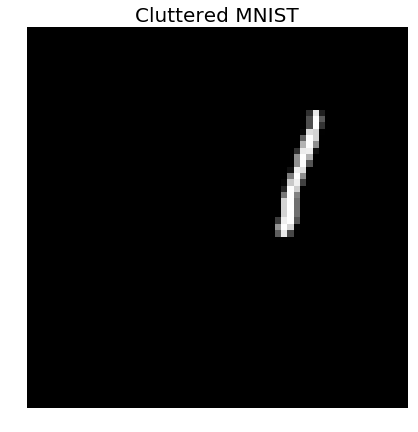

In [7]:
# To see if there are any problems with the image

plt.figure(figsize=(7,7))
plt.imshow(data['X_test'][1010].reshape(DIM, DIM), cmap='gray', interpolation='none')
plt.title('Cluttered MNIST', fontsize=20)
plt.axis('off')
plt.show()


In [8]:
# Model File

def build_model(input_width, input_height, output_dim,
                batch_size=BATCH_SIZE):
    ini = lasagne.init.HeUniform()
    l_in = lasagne.layers.InputLayer(shape=(None, 1, input_width, input_height),)

    # Localization network
    b = np.zeros((2, 4), dtype=theano.config.floatX)
    b[0, 0] = 1
    b[1, 1] = 1
    b = b.flatten()
    loc_l1 = pool(l_in, pool_size=(2, 2))
    loc_l2 = conv(
        loc_l1, num_filters=20, filter_size=(5, 5), W=ini)
    loc_l3 = pool(loc_l2, pool_size=(2, 2))
    loc_l4 = conv(loc_l3, num_filters=20, filter_size=(5, 5), W=ini)
    loc_l5 = lasagne.layers.DenseLayer(
        loc_l4, num_units=50, W=lasagne.init.HeUniform('relu'))
    loc_out = lasagne.layers.DenseLayer(
        loc_l5, num_units=8, b=b, W=lasagne.init.Constant(0.0), 
        nonlinearity=lasagne.nonlinearities.identity)
    
    # Transformer network
    l_trans1 = TransformerLayer8param(l_in, loc_out, downsample_factor=3.0)
    print "Transformer network output shape: ", l_trans1.output_shape
    
    # Classification network
    class_l1 = conv(
        l_trans1,
        num_filters=32,
        filter_size=(3, 3),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=ini,
    )
    class_l2 = pool(class_l1, pool_size=(2, 2))
    class_l3 = conv(
        class_l2,
        num_filters=32,
        filter_size=(3, 3),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=ini,
    )
    class_l4 = pool(class_l3, pool_size=(2, 2))
    class_l5 = lasagne.layers.DenseLayer(
        class_l4,
        num_units=256,
        nonlinearity=lasagne.nonlinearities.rectify,
        W=ini,
    )

    l_out = lasagne.layers.DenseLayer(
        class_l5,
        num_units=output_dim,
        nonlinearity=lasagne.nonlinearities.softmax,
        W=ini,
    )

    return l_out, l_trans1, loc_out

# model --> network model
# l_transform --> the output of the transformer layer
# thetas --> output of the localizer block 

model, l_transform, thetas = build_model(DIM, DIM, NUM_CLASSES)
model_params = lasagne.layers.get_all_params(model, trainable=True)


Transformer network output shape:  (None, 1, 20, 20)


In [9]:
# train and eval functions

X = T.tensor4()
y = T.ivector()

# training output
output_train = lasagne.layers.get_output(model, X, deterministic=False)

# evaluation output. Also includes output of transform for plotting
output_eval, transform_eval, thetas_tensor = lasagne.layers.get_output([model, l_transform, thetas], X, deterministic=True)

sh_lr = theano.shared(lasagne.utils.floatX(LEARNING_RATE))
cost = T.mean(T.nnet.categorical_crossentropy(output_train, y))
cost_test = T.mean(T.nnet.categorical_crossentropy(output_eval, y))
updates = lasagne.updates.adam(cost, model_params, learning_rate=sh_lr)

train = theano.function([X, y], [cost, output_train], updates=updates)
eval = theano.function([X, y], [output_eval, transform_eval, thetas_tensor, cost_test])

/usr/local/lib/python2.7/dist-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)
WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


In [10]:
# Mini-batch SGD and Forward pass modules

def train_epoch(X, y):
    num_samples = X.shape[0]
    num_batches = int(np.ceil(num_samples / float(BATCH_SIZE)))
    loss = []
    correct = 0
    for i in range(num_batches):
        idx = range(i*BATCH_SIZE, np.minimum((i+1)*BATCH_SIZE, num_samples))
        X_batch = X[idx]
        y_batch = y[idx]
        cost_batch, output_train = train(X_batch, y_batch)
        loss += [cost_batch]
        preds = np.argmax(output_train, axis=-1)
        correct += np.sum(y_batch == preds)

    return np.mean(loss), correct / float(num_samples)


def eval_epoch(X, y):
    loss = []
    output_eval, transform_eval, actual_thetas, loss = eval(X, y)
    preds = np.argmax(output_eval, axis=-1)
    acc = np.mean(preds == y)
    return np.mean(loss), acc, transform_eval, actual_thetas, preds, output_eval


In [11]:
#EDITS SHOULD BE PERFORMED
# BEFORE TRAINING, HOW IS THE ACCURACY LIKE?
# y_test2 = np.array([1, 1, 1, 1, 4, 4, 4, 4, 7, 0, 7, 2, 2, 2, 0, 0, 0, 2, 7, 7, 3, 3, 3, 3, 6, 6, 5, 5, 5, 5, 8, 6, 8, 6, 8, 8, 9, 9, 9, 9], dtype=np.int32)
# X_test2 = np.zeros((y_test2.shape[0], 1, 60, 60), dtype=np.float32)
# for i in range(40):
#     X_test2[i] = cv2.imread("/home/dl2/caner_grad/temp/translated_ones/"+str(i)+ ".png", cv2.IMREAD_GRAYSCALE)
# for i in range(40):    
#     X_test2[i] = (X_test2[i] - np.mean(X_test2[i]))/np.std(X_test2[i])
# test_loss2, test_acc2, test_transform2, actual_thetas2, preds2, output_eval2 = eval_epoch(X_test2, y_test2)
# print "test loss {0}, test acc {1}".format(test_loss2, test_acc2)

In [12]:
# plt.figure(figsize=(7,28))
# k=20
# for i in range(k):
#     plt.subplot(k,2,1+i*2)
#     plt.imshow(X_test2[i].reshape(DIM, DIM), cmap='gray', interpolation='none')
#     if i == 0:
#         plt.title('Original 60x60', fontsize=20)
#     plt.axis('off')
#     plt.subplot(k,2,2+i*2)
#     plt.imshow(test_transform2[i].reshape(DIM//3, DIM//3), cmap='gray', interpolation='none')
#     if i == 0:
#         plt.title('Transformed 20x20', fontsize=20)
#     plt.axis('off')
# plt.tight_layout()


In [13]:
# Training
# SKIP IF THE NETWORK HAS BEEN PRETRAINED
theano.config.exception_verbosity="high"

valid_accs, train_accs = [], []
valid_losses, train_losses = [], []
test_accs = []
test_losses = []

try:
    for n in range(NUM_EPOCHS):
        train_loss, train_acc = train_epoch(data['X_train'], data['y_train'])
        val_loss, valid_acc, valid_trainsform, dummy, preds_valid, output_eval_valid  = eval_epoch(data['X_valid'], data['y_valid'])
        valid_accs += [valid_acc]
        train_accs += [train_acc]
        valid_losses += [val_loss]
        train_losses += [train_loss]
        
        np.savez('model'+str(n)+'.npz', *lasagne.layers.get_all_param_values(model))

        if (n+1) % 20 == 0:
            new_lr = sh_lr.get_value() * 0.7
            print "New LR:", new_lr
            sh_lr.set_value(lasagne.utils.floatX(new_lr))

#         print "Epoch {0}: Train loss {1}, Train acc {2}, val acc {3}, test acc {4}".format(
#                 n, train_loss, train_acc, valid_acc, test_acc) 
        print "Epoch {0}: Train loss {1}, Train acc {2}, val acc {3}".format(
                n, train_loss, train_acc, valid_acc)
#         print "Epoch {0}: Train loss {1}, Train acc {2}".format(
#                 n, train_loss, train_acc)
except KeyboardInterrupt:
    pass

Epoch 0: Train loss 1.08239138126, Train acc 0.634666666667, val acc 0.889833333333
Epoch 1: Train loss 0.260918796062, Train acc 0.918486666667, val acc 0.944866666667
Epoch 2: Train loss 0.157917439938, Train acc 0.9506, val acc 0.959433333333
Epoch 3: Train loss 0.123279079795, Train acc 0.96114, val acc 0.968066666667
Epoch 4: Train loss 0.108974784613, Train acc 0.965646666667, val acc 0.970333333333
Epoch 5: Train loss 0.0960087701678, Train acc 0.96916, val acc 0.973
Epoch 6: Train loss 0.0865200161934, Train acc 0.972786666667, val acc 0.9683
Epoch 7: Train loss 0.076320566237, Train acc 0.976126666667, val acc 0.978666666667
Epoch 8: Train loss 0.0693063288927, Train acc 0.97826, val acc 0.978233333333
Epoch 9: Train loss 0.0743781626225, Train acc 0.97644, val acc 0.972366666667
Epoch 10: Train loss 0.0663107261062, Train acc 0.97898, val acc 0.976166666667
Epoch 11: Train loss 0.0632852315903, Train acc 0.979893333333, val acc 0.971333333333
Epoch 12: Train loss 0.0635208338

In [11]:
test_accs = []
test_losses = []
preds_train = []


theano.config.exception_verbosity="high"
for i in range(101):
    with np.load('/home/dontgetdown/Documents/caner_grad/rotated_45_90_code/8_thetas/model'+str(i)+".npz") as f:
         param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    lasagne.layers.set_all_param_values(model, param_values)
    test_loss, test_acc, test_transform, actual_thetas, preds, output_eval = eval_epoch(data['X_test'][:], data['y_test'][:])
    test_accs += [test_acc]
    test_losses += [test_loss]
    preds_train += [np.argmax(output_eval, axis=-1)]

In [12]:
#TEST ACC & LOSS FOR MODELS 
print test_losses
print test_accs

[0.33007812, 0.1668347, 0.1139791, 0.091830015, 0.083576471, 0.079677552, 0.0943041, 0.060953531, 0.064785235, 0.08350049, 0.06779182, 0.078860335, 0.065346323, 0.050770018, 0.053849868, 0.067745596, 0.052782092, 0.069082923, 0.049465738, 0.059031658, 0.045050506, 0.047574844, 0.044143982, 0.043452531, 0.044623081, 0.04374034, 0.042675737, 0.047558062, 0.047276106, 0.043764059, 0.041369569, 0.049303576, 0.041322634, 0.043444939, 0.045947537, 0.045844242, 0.04887525, 0.051397119, 0.040981729, 0.047271822, 0.039638117, 0.04271622, 0.041438501, 0.040978126, 0.043418702, 0.04206609, 0.045276381, 0.042791758, 0.043067083, 0.043924488, 0.041908089, 0.03985161, 0.039396737, 0.046060361, 0.046633892, 0.048795775, 0.044966005, 0.04311667, 0.046241667, 0.039650522, 0.041530102, 0.042875472, 0.045631111, 0.041027881, 0.043356411, 0.043314647, 0.043352898, 0.044349387, 0.041528981, 0.044656783, 0.042326476, 0.044398535, 0.050753478, 0.049399272, 0.046311099, 0.047339559, 0.049596131, 0.053780437, 

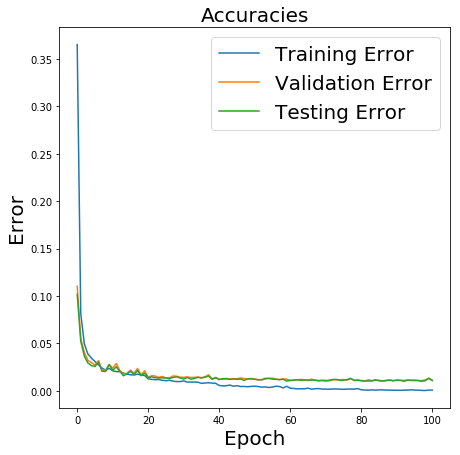

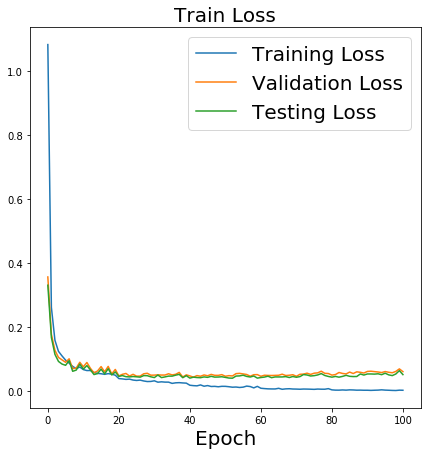

In [38]:
plt.figure(figsize=(7,7))
plt.title('Accuracies', fontsize=20)
plt.plot(1-np.array(train_accs), label='Training Error')
plt.plot(1-np.array(valid_accs), label='Validation Error')
plt.plot(1-np.array(test_accs), label='Testing Error')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Error', fontsize=20)
plt.show()

plt.figure(figsize=(7,7))
plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(len(valid_losses)), valid_losses, label='Validation Loss')
plt.plot(range(len(test_losses)), test_losses, label='Testing Loss')
plt.xlabel('Epoch', fontsize=20)
plt.legend(fontsize=20)
plt.title('Train Loss', fontsize=20)
plt.show()


3


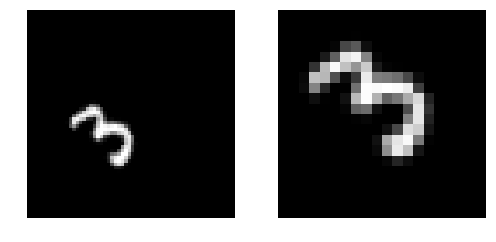

In [14]:
# Spatial Transformer I/O
plt.figure(figsize=(7,14))
k=1
l = 23305
for i in [l+j for j in range(k)]:
    plt.subplot(k,2,1+(i-l)*2)
    plt.imshow(data['X_test'][i].reshape(DIM, DIM), cmap='gray', interpolation='none')
    if i == 0:
        plt.title('Original 60x60', fontsize=20)
    plt.axis('off')
    plt.subplot(k,2,2+(i-l)*2)
    plt.imshow(test_transform[i].reshape(DIM//3, DIM//3), cmap='gray', interpolation='none')
    if i == 0:
        plt.title('Transformed 20x20', fontsize=20)
    plt.axis('off')
plt.tight_layout()
print np.argmax(output_eval, axis=1)[l]

In [15]:
print actual_thetas[l:l+k] 

[[ 0.51907754 -0.00361293 -0.0083427  -0.21191558  0.02880955  0.51611298
  -0.00879138  0.2763072 ]]


In [ ]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap              )
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=60)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float16') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, np.around(cm[i, j],decimals = 3),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
plt.figure(figsize = (7,7))
y_true = data['y_test'][20000:30000]
y_pred = np.argmax(output_eval, axis=1)[20000:30000]

cnf_matrix = confusion_matrix(y_true, y_pred)

class_names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')



In [ ]:
plt.figure(figsize = (7,7))

plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')